In [1]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("CWD =", os.getcwd())



CWD = C:\Users\linzi\shopping_cart_analysis\data\processed


In [2]:
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
SUPPORT_LIST = [0.02, 0.01, 0.005]

MAX_LEN = 3
METRIC = "confidence"
MIN_THRESHOLD = 0.3

FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1

# Chỉ giữ phần đủ yêu cầu
PLOT_RULES_COUNT = True
PLOT_AVG_METRICS = True
PLOT_METRICS_DISTRIBUTION = True


In [3]:
import os, importlib.util

root = os.getcwd()
while root and not os.path.isdir(os.path.join(root, "src")):
    parent = os.path.dirname(root)
    if parent == root:
        break
    root = parent

print("Detected ROOT =", root)
print("Has src? ", os.path.isdir(os.path.join(root, "src")))

module_path = os.path.join(root, "src", "apriori_library.py")
print("Module path =", module_path)
print("Exists?", os.path.exists(module_path))

spec = importlib.util.spec_from_file_location("apriori_library", module_path)
apriori_library = importlib.util.module_from_spec(spec)
spec.loader.exec_module(apriori_library)

AssociationRulesMiner = apriori_library.AssociationRulesMiner
print("Import OK:", AssociationRulesMiner)



Detected ROOT = C:\Users\linzi\shopping_cart_analysis
Has src?  True
Module path = C:\Users\linzi\shopping_cart_analysis\src\apriori_library.py
Exists? True
Import OK: <class 'apriori_library.AssociationRulesMiner'>


In [4]:
import os
os.chdir(root)
print("CWD set to:", os.getcwd())


CWD set to: C:\Users\linzi\shopping_cart_analysis


In [5]:
import pandas as pd
basket_bool = pd.read_parquet("data/processed/basket_bool.parquet")
print("Basket shape:", basket_bool.shape)


Basket shape: (18021, 4007)


In [6]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)
print("Basket shape:", basket_bool.shape)
basket_bool.head()


Basket shape: (18021, 4007)


,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
rules_by_support = {}
summary_rows = []

for supp in SUPPORT_LIST:
    print(f"\n=== min_support={supp} ===")
    miner = AssociationRulesMiner(basket_bool=basket_bool)

    itemsets = miner.mine_frequent_itemsets(
        min_support=supp,
        max_len=MAX_LEN,
        use_colnames=True,
    )
    rules = miner.generate_rules(metric=METRIC, min_threshold=MIN_THRESHOLD)
    rules = miner.add_readable_rule_str()

    rules_filtered = miner.filter_rules(
        min_support=supp,
        min_confidence=FILTER_MIN_CONF,
        min_lift=FILTER_MIN_LIFT,
        max_len_antecedents=FILTER_MAX_ANTECEDENTS,
        max_len_consequents=FILTER_MAX_CONSEQUENTS,
    )

    print(f"- frequent itemsets: {len(itemsets):,}")
    print(f"- rules raw: {len(rules):,}")
    print(f"- rules filtered: {len(rules_filtered):,}")

    rules_by_support[supp] = rules_filtered.copy()

    if len(rules_filtered) == 0:
        summary_rows.append([supp, 0, np.nan, np.nan, np.nan])
    else:
        summary_rows.append([
            supp,
            len(rules_filtered),
            rules_filtered["lift"].mean(),
            rules_filtered["confidence"].mean(),
            rules_filtered["support"].mean(),
        ])

summary_df = pd.DataFrame(
    summary_rows,
    columns=["min_support", "Số luật", "Lift TB", "Confidence TB", "Support TB"],
).sort_values("min_support", ascending=False)

display(summary_df)



=== min_support=0.02 ===
- frequent itemsets: 400
- rules raw: 184
- rules filtered: 175

=== min_support=0.01 ===
- frequent itemsets: 2,120
- rules raw: 2,008
- rules filtered: 1,794

=== min_support=0.005 ===
- frequent itemsets: 18,617
- rules raw: 25,772
- rules filtered: 24,255


,min_support,Số luật,Lift TB,Confidence TB,Support TB
0,0.020,175,8.842168,0.498664,0.024912
1,0.010,1794,13.570162,0.535189,0.013850
2,0.005,24255,14.167382,0.553944,0.006773


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
print("Plot imports OK")


Plot imports OK


C:\Users\linzi\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\linzi\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\linzi\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


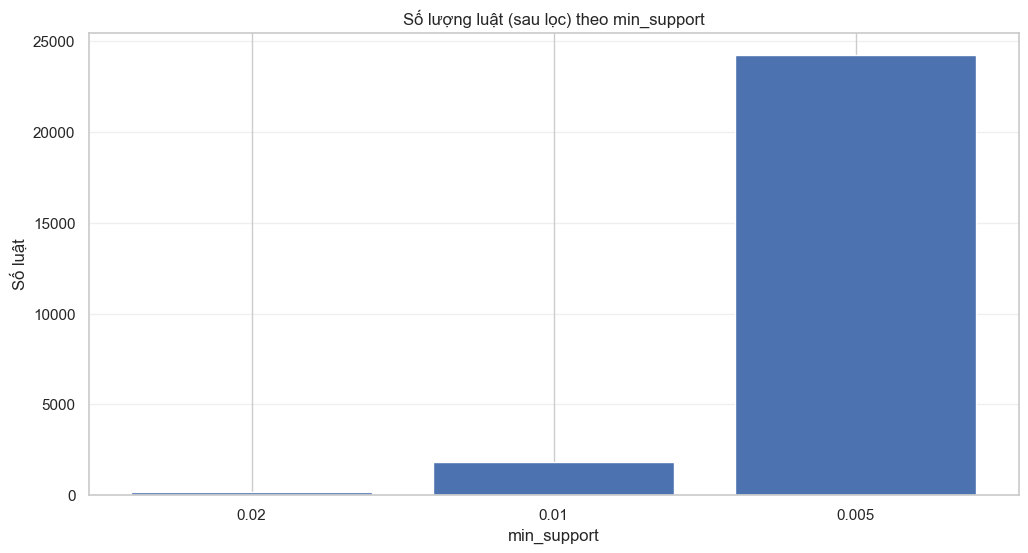

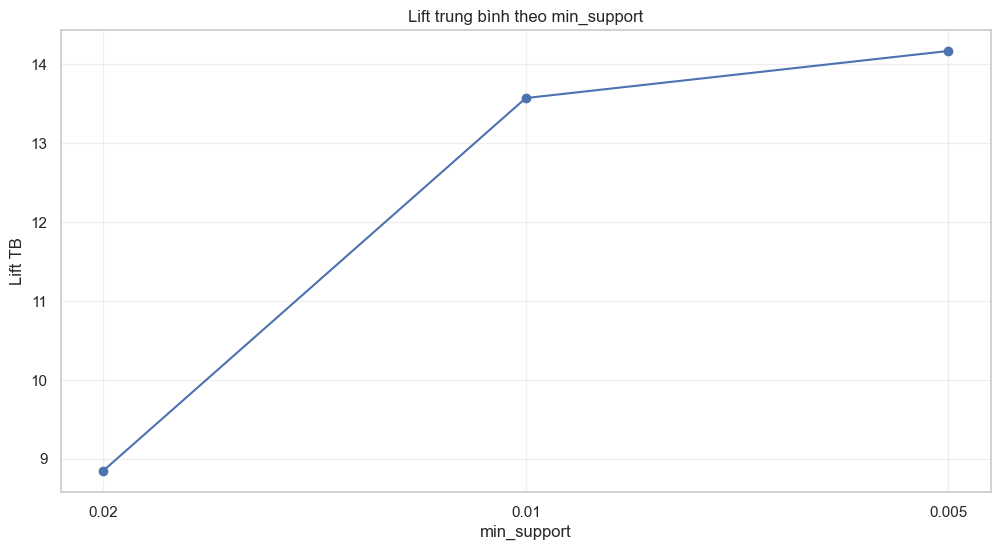

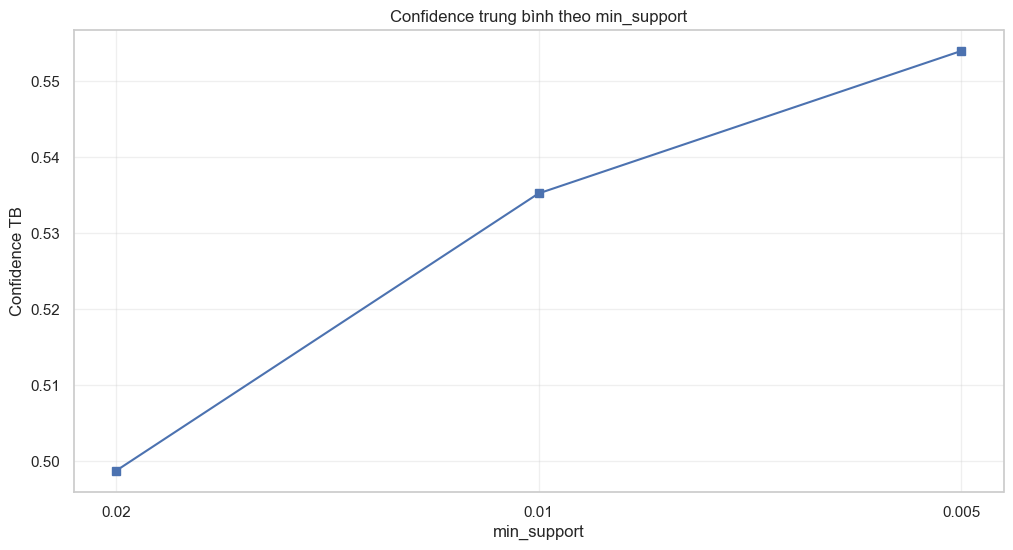

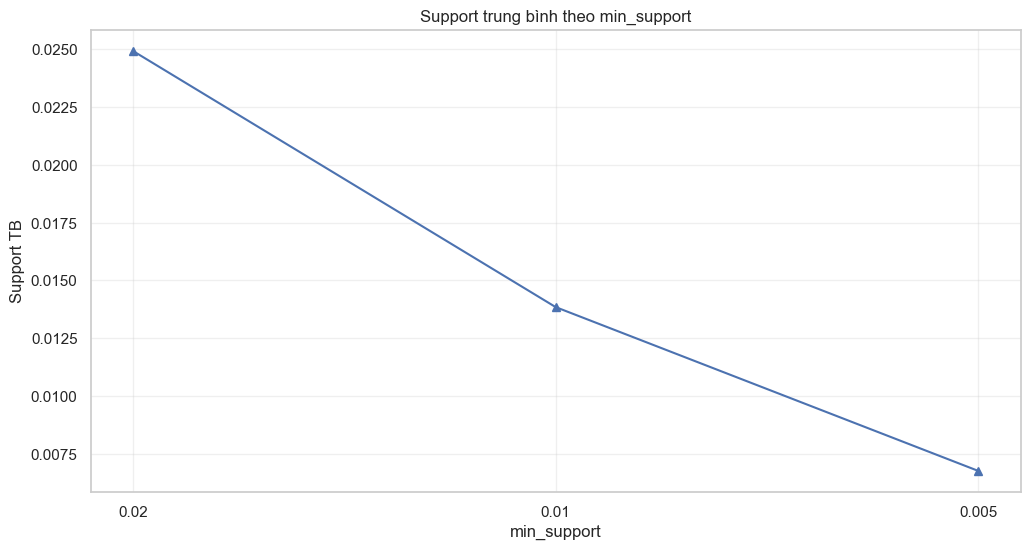

In [10]:
# 1) Số lượng luật theo min_support
plt.figure()
plt.bar(summary_df["min_support"].astype(str), summary_df["Số luật"])
plt.title("Số lượng luật (sau lọc) theo min_support")
plt.xlabel("min_support")
plt.ylabel("Số luật")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# 2) Lift/Confidence/Support trung bình theo min_support
for col, title, marker in [
    ("Lift TB", "Lift trung bình", "o"),
    ("Confidence TB", "Confidence trung bình", "s"),
    ("Support TB", "Support trung bình", "^"),
]:
    plt.figure()
    plt.plot(summary_df["min_support"].astype(str), summary_df[col], marker=marker)
    plt.title(f"{title} theo min_support")
    plt.xlabel("min_support")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.show()


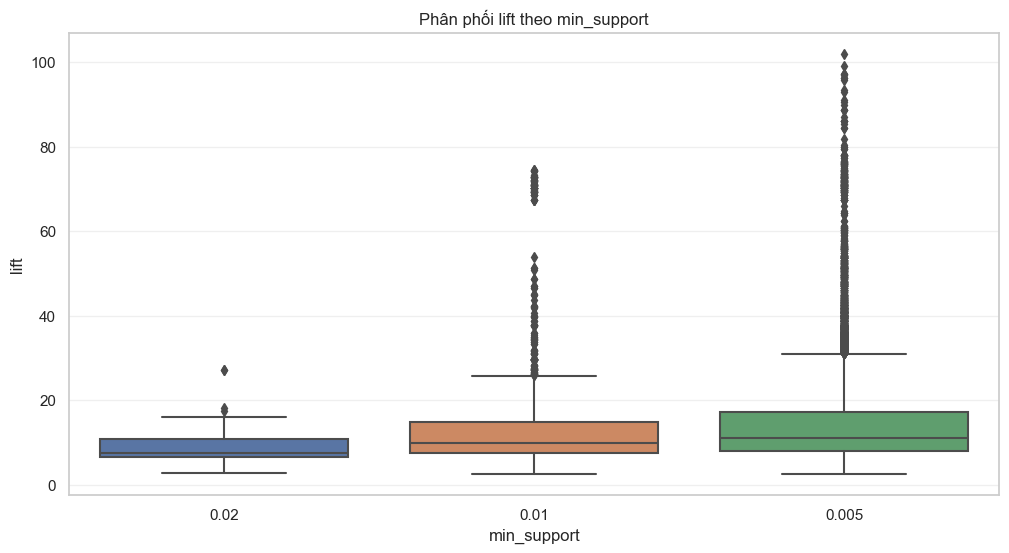

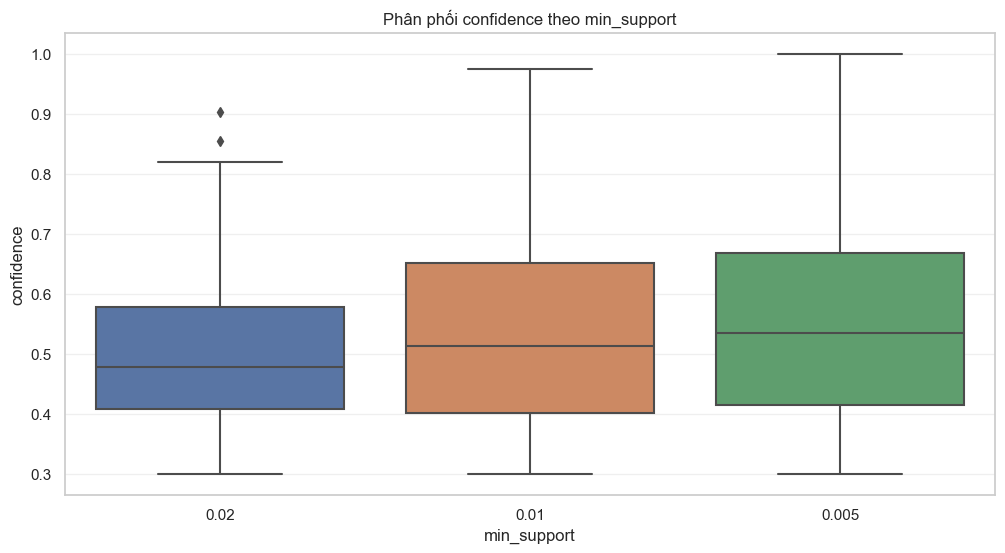

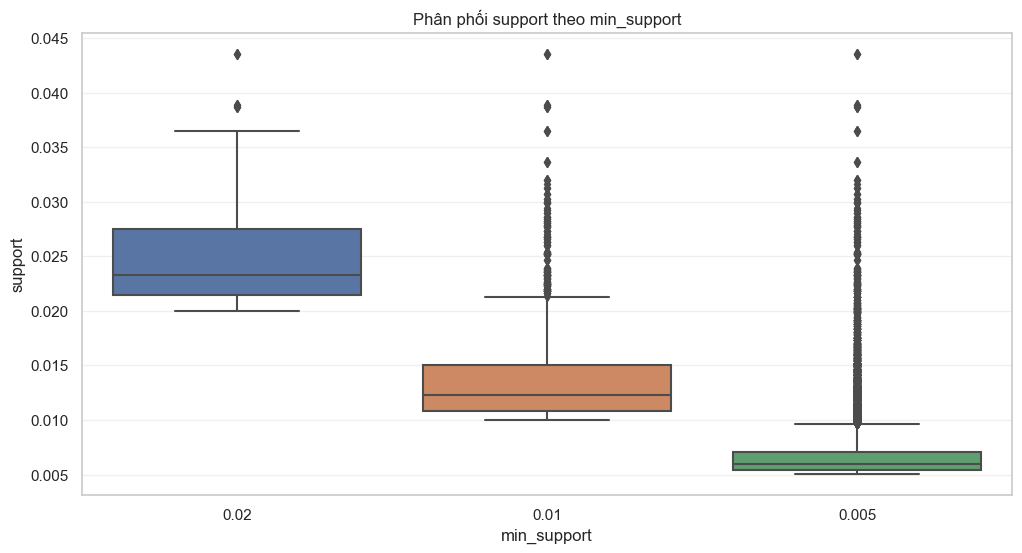

In [11]:
rows = []
for supp, rdf in rules_by_support.items():
    if rdf is None or len(rdf) == 0:
        continue
    tmp = rdf[["lift", "confidence", "support"]].copy()
    tmp["min_support"] = str(supp)
    rows.append(tmp)

if len(rows) == 0:
    print("Không có luật sau lọc để vẽ boxplot.")
else:
    comp_df = pd.concat(rows, ignore_index=True)

    for metric in ["lift", "confidence", "support"]:
        plt.figure()
        sns.boxplot(data=comp_df, x="min_support", y=metric)
        plt.title(f"Phân phối {metric} theo min_support")
        plt.xlabel("min_support")
        plt.ylabel(metric)
        plt.grid(True, axis="y", alpha=0.3)
        plt.show()


In [ ]:
Phân tích độ nhạy của luật kết hợp theo tham số min_support

Dựa trên kết quả thực nghiệm với các giá trị min_support = 0.02, 0.01, 0.005, có thể rút ra các nhận định sau:

1. Ảnh hưởng của min_support đến số lượng luật

Khi min_support = 0.02, hệ thống chỉ sinh ra 175 luật, tập trung vào các mẫu mua hàng phổ biến nhất.

Khi giảm xuống min_support = 0.01, số luật tăng mạnh lên 1.794 luật (tăng hơn 10 lần).

Ở mức rất thấp min_support = 0.005, số luật bùng nổ lên 24.255 luật, cho thấy số lượng luật tăng phi tuyến khi giảm ngưỡng support.

➡️ Điều này cho thấy min_support là tham số ảnh hưởng mạnh nhất đến số lượng luật kết hợp được phát hiện.

2. Ảnh hưởng đến chất lượng luật (Lift, Confidence, Support)

Lift trung bình tăng từ 8.84 → 13.57 → 14.17 khi min_support giảm, cho thấy các luật hiếm thường có mối liên hệ mạnh hơn.

Confidence trung bình cũng tăng từ 0.50 → 0.54 → 0.55, phản ánh độ tin cậy của luật có xu hướng cải thiện khi xét các mẫu hiếm.

Ngược lại, Support trung bình giảm mạnh từ 0.0249 → 0.0139 → 0.0068, đúng với bản chất của các luật hiếm.

➡️ Các luật ở min_support thấp có độ mạnh cao hơn nhưng tần suất xuất hiện thấp hơn, dễ gây nhiễu nếu không lọc kỹ.

3. Đánh giá ngưỡng min_support hợp lý

min_support = 0.02:

Ít luật, dễ phân tích, phù hợp cho ứng dụng đại trà (cross-selling phổ biến).

min_support = 0.01:

Cân bằng giữa số lượng luật và chất lượng luật, vẫn đảm bảo khả năng tính toán.

min_support = 0.005:

Sinh ra rất nhiều luật (hơn 24 nghìn), chi phí tính toán cao, khó khai thác thực tế.

👉 Kết luận cuối cùng

Ngưỡng min_support = 0.01 được xem là phù hợp nhất cho bộ dữ liệu này vì:

Số lượng luật đủ lớn để khai thác thông tin

Lift và Confidence trung bình cao

Không gây bùng nổ số luật như khi min_support quá thấp